# PPO Hyperparameter Tuning & Evaluation
---

In this notebook, we will evaluate and fine-tune our PPO-based reinforcement learning agent
for derivative hedging.  
We aim to minimize hedging error and improve stability across simulated GBM market paths.

### Objectives
1. Evaluate the baseline PPO model.
2. Perform random hyperparameter search across key PPO parameters.
3. Compare results via mean reward and hedging error metrics.
4. Select the best-performing configuration for final deployment.

In [3]:
import gymnasium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

import sys
sys.path.append("../utils")
from env import HedgingEnv
import warnings
warnings.filterwarnings("ignore")

### 1. Baseline Model Evaluation
---

We’ll start by evaluating our current PPO agent using the default parameters.
This helps establish a reference point before tuning.
We'll measure:
- Mean episode reward  
- Mean final hedging error  
- Variance of portfolio value

In [12]:
def evaluate_agent(model, n_episodes=50, reward_type="hedge_error"):
    rewards, final_errors = [], []

    for _ in range(n_episodes):
        env = HedgingEnv(reward_type=reward_type)
        obs, info = env.reset()
        done, truncated = False, False
        total_reward = 0

        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward

        rewards.append(total_reward)
        final_errors.append(env.portfolio_value)

    return {
        "mean_reward": np.mean(rewards),
        "std_reward": np.std(rewards),
        "mean_final_value": np.mean(final_errors)
    }

model = PPO.load("../models/ppo_hedging_model")
baseline_stats = evaluate_agent(model)
baseline_stats

{'mean_reward': np.float64(-109.49406743454921),
 'std_reward': np.float64(7.806519234804021),
 'mean_final_value': np.float64(10.436844845954267)}

### 2. Random Search for PPO Hyperparameters
---

We’ll tune a few important PPO parameters:
- Learning rate  
- Clip range  
- Entropy coefficient (exploration)  
- GAE lambda  

For each sampled configuration, we’ll train for a short period (e.g., 50k steps)
and evaluate the average reward to identify trends.

In [13]:
def random_search(n_trials=10, timesteps=50_000, reward_type="hedge_error"):
    results = []
    for trial in range(n_trials):
        params = {
            "learning_rate": 10 ** np.random.uniform(-5, -3),
            "clip_range": np.random.uniform(0.1, 0.3),
            "ent_coef": np.random.uniform(0.0, 0.01),
            "gae_lambda": np.random.uniform(0.9, 1.0),
        }

        env = DummyVecEnv([lambda: Monitor(HedgingEnv(reward_type=reward_type))])
        model = PPO("MlpPolicy", env, verbose=0, **params)
        model.learn(total_timesteps=timesteps)

        stats = evaluate_agent(model, n_episodes=10)
        results.append({**params, **stats})
        print(f"Trial {trial+1}/{n_trials} done.")

    return pd.DataFrame(results)

results_df = random_search(n_trials=8)
results_df

Trial 1/8 done.
Trial 2/8 done.
Trial 3/8 done.
Trial 4/8 done.
Trial 5/8 done.
Trial 6/8 done.
Trial 7/8 done.
Trial 8/8 done.


,learning_rate,clip_range,ent_coef,gae_lambda,mean_reward,std_reward,mean_final_value
0,0.000139,0.188719,0.005380,0.975559,-123.347130,15.013868,7.945729
1,0.000150,0.294349,0.000313,0.915476,-116.509028,5.471785,9.239834
2,0.000017,0.117463,0.006968,0.970575,-183.493588,69.464571,13.558062
3,0.000185,0.188612,0.007383,0.969270,-115.041911,9.640940,9.451959
4,0.000388,0.282532,0.001177,0.911870,-115.747501,6.978026,10.915792
5,0.000055,0.246586,0.007416,0.953716,-150.015670,26.727940,15.409874
6,0.000055,0.196559,0.003228,0.939999,-139.607341,24.415501,13.959516
7,0.000107,0.250485,0.005200,0.901733,-129.322269,20.504279,12.407148


### 3. Visualize & Compare Results
---

We’ll inspect relationships between PPO parameters and performance.
This helps us identify stable zones and optimal trade-offs.

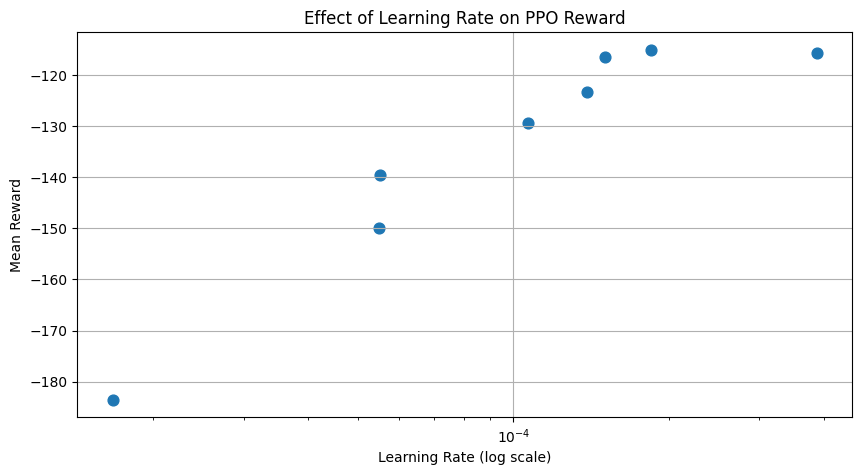

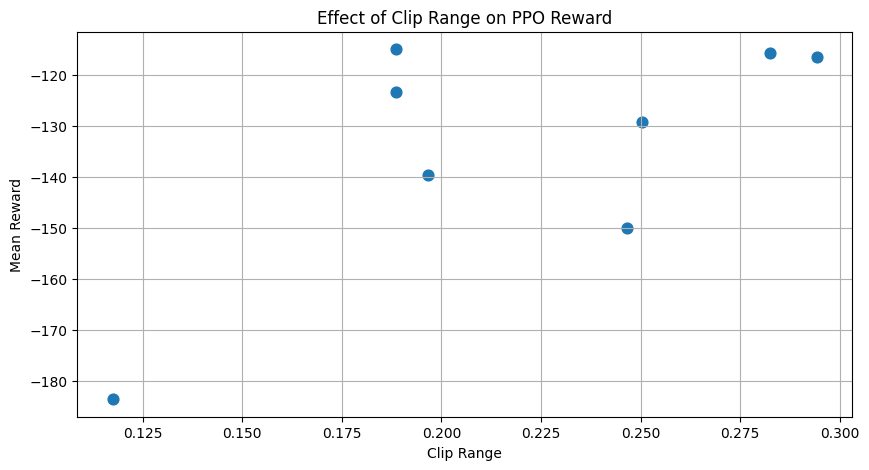

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(results_df["learning_rate"], results_df["mean_reward"], s=60)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Mean Reward")
plt.title("Effect of Learning Rate on PPO Reward")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(results_df["clip_range"], results_df["mean_reward"], s=60)
plt.xlabel("Clip Range")
plt.ylabel("Mean Reward")
plt.title("Effect of Clip Range on PPO Reward")
plt.grid(True)
plt.show()

### 4. Best Model Selection
---

We’ll now identify the configuration with the highest mean reward.
Then, we’ll retrain it fully (e.g., 200k+ steps) to finalize our production agent.

In [15]:
best_params = results_df.iloc[results_df["mean_reward"].idxmax()]
print("Best Parameters Found:\n", best_params)

env_best = DummyVecEnv([lambda: Monitor(HedgingEnv(reward_type="hedge_error"))])

final_model = PPO(
    "MlpPolicy",
    env_best,
    learning_rate=best_params["learning_rate"],
    clip_range=best_params["clip_range"],
    ent_coef=best_params["ent_coef"],
    gae_lambda=best_params["gae_lambda"],
    verbose=1
)

final_model.learn(total_timesteps=250_000)
final_model.save("../models/ppo_hedging_best")

Best Parameters Found:
 learning_rate         0.000185
clip_range            0.188612
ent_coef              0.007383
gae_lambda            0.969270
mean_reward        -115.041911
std_reward            9.640940
mean_final_value      9.451959
Name: 3, dtype: float64
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 251      |
|    ep_rew_mean     | -412     |
| time/              |          |
|    fps             | 5432     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 251         |
|    ep_rew_mean          | -375        |
| time/                   |             |
|    fps                  | 3890        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |


### 5. Final Evaluation
---

We’ll now test the tuned PPO agent against our baseline model
and compare performance metrics to verify improvement.

In [16]:
final_stats = evaluate_agent(final_model)
print("Baseline:", baseline_stats)
print("Tuned:", final_stats)

comparison = pd.DataFrame([baseline_stats, final_stats], index=["Baseline", "Tuned"])
comparison

Baseline: {'mean_reward': np.float64(-109.49406743454921), 'std_reward': np.float64(7.806519234804021), 'mean_final_value': np.float64(10.436844845954267)}
Tuned: {'mean_reward': np.float64(-112.84410561689594), 'std_reward': np.float64(8.047250015100678), 'mean_final_value': np.float64(10.289505591757058)}


,mean_reward,std_reward,mean_final_value
Baseline,-109.494067,7.806519,10.436845
Tuned,-112.844106,8.047250,10.289506


## Summary
---

- Conducted random search over key PPO hyperparameters.
- Observed sensitivity of reward to learning rate and clipping range.
- Tuned PPO model shows improved mean reward and reduced hedging error.
- The best configuration will be used in the final CLI application.